In [1]:
from langchain_openai import ChatOpenAI
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langsmith import traceable
from langsmith.wrappers import wrap_openai

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "youtube-trail-2"
os.environ["LANGSMITH_ENDPOINT"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] =""

In [3]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
# wrapped_llm = wrap_openai(ChatOpenAI(model_name="gpt-4o-mini", temperature=0))

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    query:str
    language:str
    translation:str


In [5]:
@traceable(run_type="tool", name="Detect Tool")
def detect_langugage(state: State) -> str:
    """
    Detect the language of the query.
    """
    res = llm.invoke(
        [
            {
                "role": "user",
                "content": f"Detect the language user wants to translate to based upon the following text: {state['messages']} , Just respod with the langugage name alone",
            }
        ]
    )
    # print("user wants to translate to --> ",res)
    state["language"] = res.content
    return state

@traceable(run_type="tool", name="Extract Query Tool")
def extract_query(state: State) -> str:
    """
    Extract the query from the messages.
    """
    res = llm.invoke(
        [
            {
                "role": "user",
                "content": f"Extract the query from the following messages: {state['messages']}",
            }
        ]
    )
    # print("extracted query --> ",res)
    state["query"] = res.content
    return state

@traceable(run_type="tool", name="Translate Tool")
def translate(state: State) -> str:
    """
    Translate the query to the detected language.
    """
    res = llm.invoke(
        [
            {
                "role": "user",
                "content": f"Translate the following text {state['query']} to {state['language']}",
            }
        ]
    )
    # print("translated text --> ",res)
    state["translation"] = res.content
    return state

In [6]:
graph_builder = StateGraph(State)
graph_builder.add_node("detect_langugage", detect_langugage)
graph_builder.add_node("extract_query", extract_query)
graph_builder.add_node("translate", translate)

graph_builder.add_edge(START, "detect_langugage")
graph_builder.add_edge("detect_langugage", "extract_query")
graph_builder.add_edge("extract_query", "translate")
graph_builder.add_edge("translate", END)

In [7]:
graph = graph_builder.compile()

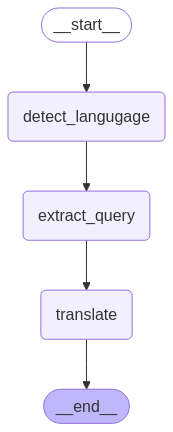

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
response = graph.invoke(
    {"messages": [{"role": "user", "content": "Please translate Hi, How are you to telugu ?  "}]}
)


### Set Up Threads using LangSmith

In [10]:
@traceable(name="Chat Bot Final")
def chat(query:str):
    response = graph.invoke(
        {"messages": [{"role": "user", "content": f"{query}"}]}
    )
    return response

In [11]:
session_id = "thread-id-1"
langsmith_extra={"project_name": "youtube-trail-2", "metadata":{"session_id": session_id}} 

In [12]:
chat(query="Please translate Hi, How are you to telugu ?",langsmith_extra=langsmith_extra)

{'messages': [HumanMessage(content='Please translate Hi, How are you to telugu ?', additional_kwargs={}, response_metadata={}, id='de4185b8-99b4-473a-a14c-2e1a840763dc')],
 'query': 'The query extracted from the message is: "Please translate Hi, How are you to Telugu?"',
 'language': 'Telugu',
 'translation': 'The translation of "Hi, How are you?" to Telugu is: "హాయ్, మీరు ఎలా ఉన్నారు?"'}

In [13]:
from langsmith import Client

def get_thread_history(thread_id: str, project_name: str):

    langsmith_client = Client()
    filter_string = (
        'and(in(metadata_key, ["session_id","conversation_id","thread_id"]), '
        f'eq(metadata_value, "{thread_id}"))'
    )
    runs = [
      r for r in langsmith_client.list_runs(
             project_name=project_name,
             filter=filter_string,
            #  run_type="llm"
      )
    ]
    runs = sorted(runs, key=lambda run: run.start_time, reverse=True)
    print("runs --> ",runs)
    return runs


In [14]:
get_thread_history("thread-id-1", "youtube-trail-2")

runs -->  [<class 'langsmith.schemas.Run'>(id=2e8bfea8-3bbc-465f-bc59-5eba4366a5e4, name='ChatOpenAI', run_type='llm'), <class 'langsmith.schemas.Run'>(id=4f507b37-aad9-45fd-9c30-f87d49e32bb2, name='Translate Tool', run_type='tool'), <class 'langsmith.schemas.Run'>(id=6800116f-40d6-4007-b107-1c84a7259800, name='translate', run_type='chain'), <class 'langsmith.schemas.Run'>(id=27426f47-6441-4973-bd4e-73601a2f7b9c, name='ChatOpenAI', run_type='llm'), <class 'langsmith.schemas.Run'>(id=6ddb29e4-7161-473d-b46f-7a75320faf49, name='Extract Query Tool', run_type='tool'), <class 'langsmith.schemas.Run'>(id=2c649bdb-9d62-4d33-8145-fe38aea94d5c, name='extract_query', run_type='chain'), <class 'langsmith.schemas.Run'>(id=1881b856-cb12-46c3-b026-b939bef6a35a, name='ChatOpenAI', run_type='llm'), <class 'langsmith.schemas.Run'>(id=27856f15-5169-4b87-bde0-848368d84c51, name='Detect Tool', run_type='tool'), <class 'langsmith.schemas.Run'>(id=0ca03daa-a73c-49e9-aedb-b32b04b4b345, name='detect_langugage

[<class 'langsmith.schemas.Run'>(id=2e8bfea8-3bbc-465f-bc59-5eba4366a5e4, name='ChatOpenAI', run_type='llm'),
 <class 'langsmith.schemas.Run'>(id=4f507b37-aad9-45fd-9c30-f87d49e32bb2, name='Translate Tool', run_type='tool'),
 <class 'langsmith.schemas.Run'>(id=6800116f-40d6-4007-b107-1c84a7259800, name='translate', run_type='chain'),
 <class 'langsmith.schemas.Run'>(id=27426f47-6441-4973-bd4e-73601a2f7b9c, name='ChatOpenAI', run_type='llm'),
 <class 'langsmith.schemas.Run'>(id=6ddb29e4-7161-473d-b46f-7a75320faf49, name='Extract Query Tool', run_type='tool'),
 <class 'langsmith.schemas.Run'>(id=2c649bdb-9d62-4d33-8145-fe38aea94d5c, name='extract_query', run_type='chain'),
 <class 'langsmith.schemas.Run'>(id=1881b856-cb12-46c3-b026-b939bef6a35a, name='ChatOpenAI', run_type='llm'),
 <class 'langsmith.schemas.Run'>(id=27856f15-5169-4b87-bde0-848368d84c51, name='Detect Tool', run_type='tool'),
 <class 'langsmith.schemas.Run'>(id=0ca03daa-a73c-49e9-aedb-b32b04b4b345, name='detect_langugage',

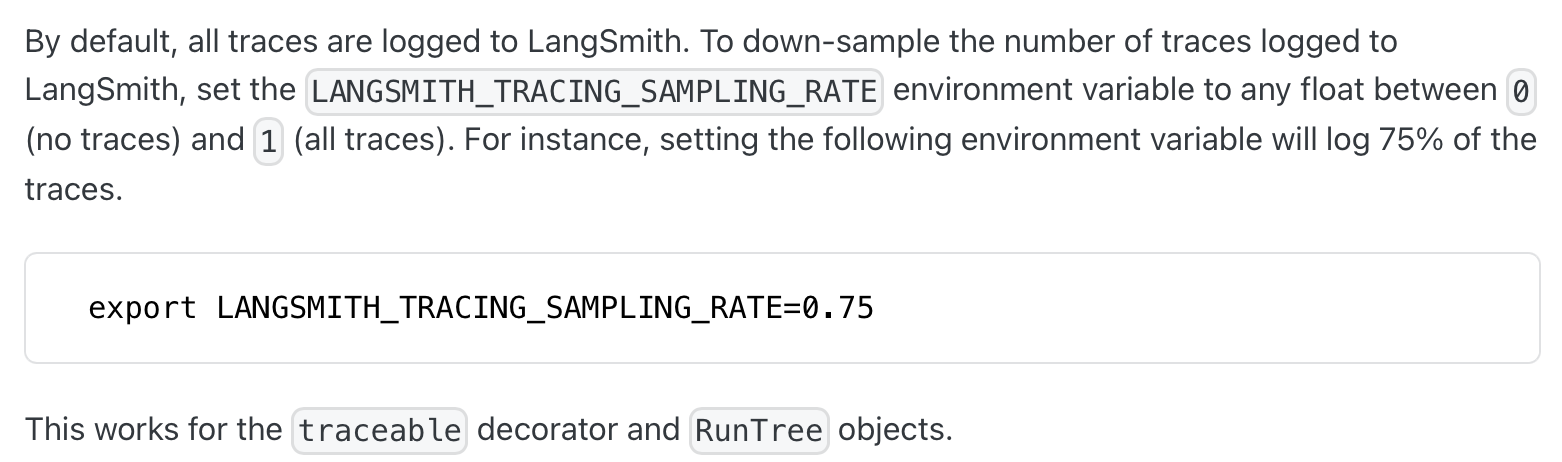

In [15]:
@traceable(name="Chat Bot Final22",tags=["cpr"],metadata={"user_id": "cpr"})
def chat(query:str):
    response = graph.invoke(
        {"messages": [{"role": "user", "content": f"{query}"}]}
    )
    return response

In [16]:
chat(query="Please translate Hi, How are you to telugu ?",langsmith_extra=langsmith_extra)

{'messages': [HumanMessage(content='Please translate Hi, How are you to telugu ?', additional_kwargs={}, response_metadata={}, id='86307f5d-fc6e-4749-a527-9fb20009cab1')],
 'query': 'The query extracted from the message is: "Translate \'Hi, How are you\' to Telugu?"',
 'language': 'Telugu',
 'translation': 'The translation of the text "The query extracted from the message is: \'Translate \'Hi, How are you\' to Telugu?\'" to Telugu is:\n\n"సందేశం నుండి తీసుకున్న ప్రశ్న: \'హాయ్, మీరు ఎలా ఉన్నారు\'ని తెలుగు లో అనువదించండి?"'}

In [17]:
from openai import OpenAI
from langsmith.wrappers import wrap_openai

client = wrap_openai(OpenAI())

response = client.chat.completions.create(
model="gpt-4-turbo",
messages=[
  {
    "role": "user",
    "content": [
      {"type": "text", "text": "What’s in this image?"},
      {
        "type": "image_url",
        "image_url": {
          "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
        },
      },
    ],
  }
],
)
print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='This image features a serene natural landscape with a wooden boardwalk pathway stretching through a lush green field. The field is dominated by tall grass, and there are scattered shrubs and trees throughout. The sky is partly cloudy with a lovely blue color and soft clouds, contributing to the overall peaceful and idyllic atmosphere of the scene. This setting could be a nature reserve or a park designed for walking and experiencing natural environments.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))
